In [1]:
import numpy as np, tqdm, pickle 
from matplotlib import pyplot as plt
from GIF_Saver import *

plt.rcParams['figure.dpi'] = 100

In [2]:
"""
 (0, 0)------->
   |          y
   |
   |
   V x
"""
pass

In [3]:
def draw_bodies(body_map):
    """
    Draws LBM Rigid body map using plt.imshow

    parameters:
        body_map (np.array)
    """
    
    plt.imshow(body_map, cmap = 'Greys', interpolation='none')
    plt.xlabel('x cell', fontsize = 9)
    plt.ylabel('y cell', fontsize = 9)
    plt.show()

In [4]:
def equi_state(ux, uy, rho, e, c, w):
    """
    Computes F-function equilibrium state for current configuration

    parameters:
        ux (np.array)
        uy (np.array)
        rho (np.array) - density
        e (np.array)   - lattice direction vectors
    
    returns:    
        np.array 9*Nx*Ny
    """

    Nx, Ny = ux.shape
    u_proj = np.zeros((9, Nx, Ny))

    for i in range(9):
        u_proj[i] = (ux*e[i,0] + uy*e[i,1])/c**2 

    f_equi = np.zeros_like(u_proj)
    u_2    = (ux**2 + uy**2) / c**2

    for i in range(9):
        f_equi[i] = rho * w[i] * (1 + u_proj[i] + u_proj[i]**2/2 - u_2/2)
    
    return f_equi

In [5]:
def iter_step(f, f_ini, bodies, ux, uy, rho, visc, e, c, w, opposites):
    """
    Performs LBM simulation step 

    parameters:
        f (np.array)      - dist function
        f_ini (np.array)
        bodies (np.array) - obstacles array
        ux (np.array) 
        uy (np.array) 
        rho (np.array) 
        visc (float) - viscosity parameter
        e (np.array) - lattice speed direction
        c (float)    - lattice sound speed 
        w (np.array) - lattice weights
        opposites (list) - opposite directions list

    returns:
        ux, uy, rho, f (np.array) 
    """

    Nx, Ny = rho.shape
    
    # Streaming
    for i in range(9):
        f[i] = np.roll(f[i], shift = e[i][::-1], axis = (0,1))
    

    # Obstacles BC
    for i in range(9):
        f[i, np.roll(bodies, shift = e[i], axis = (0,1))] = f[opposites[i], np.roll(bodies, shift = e[i], axis = (0,1))]

    # New density and velocity
    rho = np.sum(f, axis = 0)

    ux = np.zeros_like(rho)
    uy = np.zeros_like(rho)

    for i in range(9):
        ux += f[i] * e[i, 0]
        uy += f[i] * e[i, 1]

    ux /= rho 
    uy /= rho
    
    # Collision step 
    f = f + (equi_state(ux, uy, rho, e, c ,w) - f) / (1/2 + visc/c**2)

    # Inlet & Outlet BC:
    f[:, 0, :] = f_ini[:, 0, :]
    f[:,-1, :] = f_ini[:,-1, :]
    f[:, :, 0] = f_ini[:, :, 0]
    f[:, :,-1] = f_ini[:, :,-1]

    return ux, uy, rho, f

In [6]:
def naca_4digit_airfoil_mask(Nx, Ny, m, p, t):
    """
    https://en.wikipedia.org/wiki/NACA_airfoil
    
    Generates a 2D Nx by Ny array representing a NACA 4-digit airfoil shape.
    
    Parameters:
        Nx (int): Grid size in the x-direction.
        Ny (int): Grid size in the y-direction.
        m (float): Maximum camber (e.g., 0.02 for 2%).
        p (float): Location of maximum camber (e.g., 0.4 for 40%).
        t (float): Maximum thickness (e.g., 0.12 for 12%).
    
    Returns:
        np.array: 2D array where 1 represents the airfoil shape and 0 is void.
    """
    # Define the grid
    x = np.linspace(0, 1, Nx)  # Chordwise positions
    y = np.linspace(-0.2, 0.2, Ny)  # Vertical positions (scaled for airfoil thickness)
    X, Y = np.meshgrid(x, y)

    # Thickness distribution
    yt = 5 * t * (0.2969 * np.sqrt(x) - 0.1260 * x - 0.3516 * x**2 +
                  0.2843 * x**3 - 0.1015 * x**4)

    # Camber line
    yc = np.where(x < p, 
                  m / p**2 * (2 * p * x - x**2),
                  m / (1 - p)**2 * ((1 - 2 * p) + 2 * p * x - x**2))

    # Upper and lower surfaces
    yu = yc + yt
    yl = yc - yt

    # Create airfoil mask
    airfoil_mask = np.zeros((Ny, Nx), dtype=int)
    for i in range(Nx):
        # Mark grid points between the upper and lower surfaces as 1
        airfoil_mask[:, i] = (Y[:, i] <= yu[i]) & (Y[:, i] >= yl[i])

    return airfoil_mask

In [7]:
""" 
Lattice parameters
"""

c = 1/np.sqrt(3)

w = np.array([
    1/36, 1/9, 1/36,
    1/9,  4/9, 1/9,
    1/36, 1/9, 1/36
])

e = np.array([
    [-1,-1],[-1, 0],[ -1,1],
    [0, -1],[ 0, 0],[ 0, 1],
    [ 1,-1],[ 1, 0],[ 1, 1]
])

opposites = list(range(9))[::-1]

In [8]:
""" 
Simulation parameters
"""

visc = 1e-2
Nx   = 100
Ny   = 200

n_iter = 6000

i_save = 10

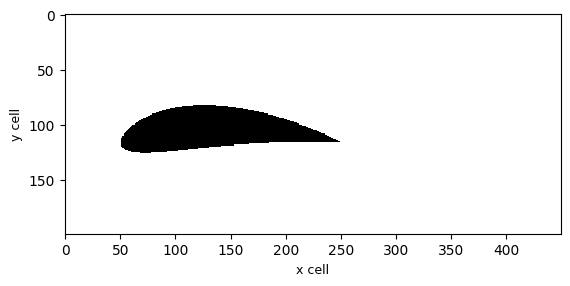

In [9]:
"""
Bodies initialization
"""

body_map = np.zeros((Nx, Ny)).astype(np.bool)

m, p, t = 0.06, 0.45, 0.16  # Maximum camber, position, and thickness
wing_map = naca_4digit_airfoil_mask(Ny, Nx, -m, p, t).astype(np.bool)

body_map = np.pad(wing_map, pad_width = [ (2*Nx//3, Nx//3), (Ny//4, Ny) ]).astype(np.bool)

draw_bodies(body_map)

In [10]:
"""
Arrays initialization
"""
Nx, Ny = body_map.shape

u0 = np.array([0.15, 0.00])

ux = np.ones((Nx, Ny)) * u0[0]
uy = np.ones((Nx, Ny)) * u0[1]

rho = np.ones((Nx, Ny))

f  = equi_state(ux, uy, rho, e, c, w)
f_ini = f.copy()

In [11]:
"""
LBM Simulation
"""

u_hist     = [ ]
unorm_hist = [ ]
curl_hist  = [ ]

for i_step in tqdm.tqdm(range(n_iter)):
    ux, uy, rho, f = iter_step(f, f_ini, body_map, ux, uy, rho, visc, e, c, w, opposites)

    u_hist.append([ux, uy])
    
    if (i_step % i_save == 0):
        unorm_hist.append(np.sqrt(ux**2 + uy**2))
        curl = np.gradient(ux, 1, axis=0) - np.gradient(uy, 1, axis=1)
        curl[body_map] = np.nan
        curl_hist.append(curl.copy())

100%|██████████| 6000/6000 [03:38<00:00, 27.51it/s]


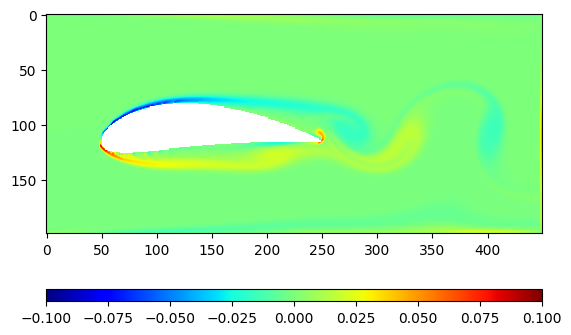

In [12]:
plt.imshow(curl_hist[-1], cmap = 'jet', vmin = -0.1, vmax = 0.1)
plt.colorbar(orientation = 'horizontal', aspect = 40)
plt.show()

In [13]:
save_GIF(curl_hist[::4], interval=35, cmap_ = 'jet', output_file='animation_3.gif', vmin = -0.025, vmax = 0.025, orient='horizontal')